In [2]:
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv("ig-analytics-clean.csv")
df.head()

,post_id,upload_date,media_type,likes,comments,shares,saves,reach,impressions,caption_length,...,engagement_depth,engagement_depth_per_10k_reach,active_engagement,passive_engagement,active_passive_ratio,caption_bucket,hashtag_bucket,engagement_quartile,reach_tier,high_reach_low_engagement
0,IG0000001,2024-11-30 09:25:22.954916,Reel,31627,7559,4530,6393,615036,1007750,1340,...,85210.0,1385.447356,18482.0,31627.0,0.584356,long,low,low,medium,False
1,IG0000002,2025-08-15 09:25:22.954916,Photo,63206,3490,1680,6809,1237071,1345900,1351,...,94014.0,759.972548,11979.0,63206.0,0.189520,long,optimal,mid-low,high,True
2,IG0000003,2025-09-11 09:25:22.954916,Reel,94373,3727,1761,8367,1127470,1305369,242,...,129332.0,1147.099258,13855.0,94373.0,0.146810,short,high,mid-low,high,True
3,IG0000004,2025-09-18 09:25:22.954916,Reel,172053,7222,2875,9290,764030,897874,446,...,223799.0,2929.191262,19387.0,172053.0,0.112680,short,optimal,high,medium,False
4,IG0000005,2025-03-21 09:25:22.954916,Video,99646,2703,4444,9746,7004,495406,1905,...,145023.0,72041.429671,16893.0,99646.0,0.169528,long,optimal,high,low,False


Outlier Handling

In [20]:
def winsorize(series, lower=0.01, upper=0.99):
    return series.clip(
        lower=series.quantile(lower),
        upper=series.quantile(upper)
    )

winsor_cols = [
    "likes", "comments", "shares", "saves",
    "reach", "impressions", "followers_gained"
]

for col in winsor_cols:
    df[f"{col}_win"] = winsorize(df[col])

Log Transformation

In [21]:
log_cols = [
    "likes_win", "comments_win", "shares_win",
    "saves_win", "reach_win", "followers_gained_win"
]

for col in log_cols:
    df[f"log_{col}"] = np.log1p(df[col])

Normalize Engagement by Reach

In [22]:
df["likes_per_10k_reach"] = (df["likes_win"] / df["reach_win"]) * 10000
df["comments_per_10k_reach"] = (df["comments_win"] / df["reach_win"]) * 10000
df["shares_per_10k_reach"] = (df["shares_win"] / df["reach_win"]) * 10000
df["saves_per_10k_reach"] = (df["saves_win"] / df["reach_win"]) * 10000
df["followers_per_10k_reach"] = (
    df["followers_gained_win"] / df["reach_win"]
) * 10000

Engagement Quality Feature Engineering

In [23]:
df["engagement_depth"] = (
    df["likes_win"]
    + 3 * df["comments_win"]
    + 4 * df["shares_win"]
    + 2 * df["saves_win"]
)

In [24]:
df["engagement_depth_per_10k_reach"] = (
    df["engagement_depth"] / df["reach_win"]
) * 10000

Active vs Passive Engagement Ratio

In [25]:
df["active_engagement"] = (
    df["comments_win"] + df["shares_win"] + df["saves_win"]
)

df["passive_engagement"] = df["likes_win"]

df["active_passive_ratio"] = (
    df["active_engagement"] / (df["passive_engagement"] + 1)
)

Content Feature Bucketing

In [26]:
df["caption_bucket"] = pd.cut(
    df["caption_length"],
    bins=[-1, 500, 1200, np.inf],
    labels=["short", "medium", "long"]
)

df["hashtag_bucket"] = pd.cut(
    df["hashtags_count"],
    bins=[-1, 5, 20, np.inf],
    labels=["low", "optimal", "high"]
)

Binary classification target

In [27]:
df["high_engagement_quality"] = (
    df["engagement_depth_per_10k_reach"]
    >= df["engagement_depth_per_10k_reach"].quantile(0.75)
).astype(int)

df["high_engagement_quality"].value_counts(normalize=True)

high_engagement_quality
0    0.749992
1    0.250008
Name: proportion, dtype: float64

One-hot Encoding

In [ ]:
df_model = pd.get_dummies(
    df,
    columns=["caption_bucket", "hashtag_bucket"],
    drop_first=True
)

Feature Selection

In [30]:
# Feature Selection
requested_features = [
    "likes_per_10k_reach",
    "comments_per_10k_reach",
    "shares_per_10k_reach",
    "saves_per_10k_reach",
    "active_passive_ratio",
    "log_reach_win",
    "caption_bucket_medium",
    "caption_bucket_long",
    "hashtag_bucket_optimal",
    "hashtag_bucket_high"
]

features = [f for f in requested_features if f in df_model.columns]

X = df_model[features]
y = df_model["high_engagement_quality"]

Train–Test Split

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

Model 1 — Logistic Regression (Baseline)

In [34]:
from sklearn.linear_model import LogisticRegression

In [35]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

Model 2 — Random Forest (Main Model)

In [36]:
from sklearn.ensemble import RandomForestClassifier

In [37]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    random_state=42
)

rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, n_estimators=200, random_state=42)

Model Evaluation

In [42]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [43]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

roc_auc_scores = cross_val_score(
    rf_model,
    X,
    y,
    cv=cv,
    scoring="roc_auc"
)

print("ROC AUC per fold:", roc_auc_scores)
print("Mean ROC AUC:", roc_auc_scores.mean())

ROC AUC per fold: [0.99958193 0.99969156 0.99957096 0.99969778 0.99963977]
Mean ROC AUC: 0.9996363988046728


In [44]:
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix
)

y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]

print("ROC AUC (Test):", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))


ROC AUC (Test): 0.9996565925925927
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4500
           1       0.99      0.98      0.99      1500

    accuracy                           0.99      6000
   macro avg       0.99      0.99      0.99      6000
weighted avg       0.99      0.99      0.99      6000



Confusion Matrix (Explainability)

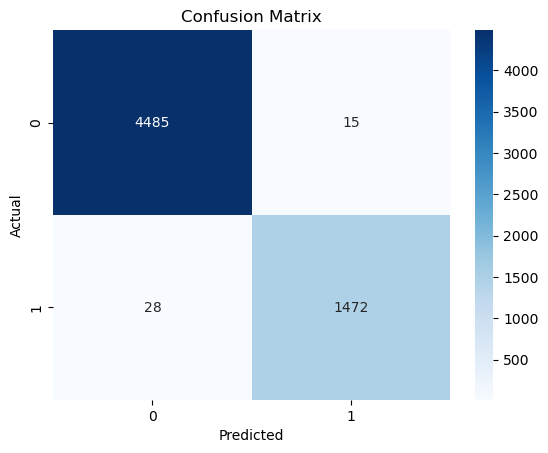

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

**Interpretation**

1. True Negatives (TN = 4485)
Low-quality posts correctly identified as low quality

2. False Positives (FP = 15)
Low-quality posts incorrectly predicted as high quality (Rate ≈ 0.33%)

3. False Negatives (FN = 28)
High-quality posts missed by the model

4. True Positives (TP = 1472)
High-quality posts correctly identified

Save Model (For Streamlit)

In [46]:
import joblib

joblib.dump(rf_model, "model.pkl")

['model.pkl']

Leakage Sanity Check

In [47]:
features

['likes_per_10k_reach',
 'comments_per_10k_reach',
 'shares_per_10k_reach',
 'saves_per_10k_reach',
 'active_passive_ratio',
 'log_reach_win',
 'caption_bucket_medium',
 'hashtag_bucket_optimal']

SHAP Explainability

In [54]:
import shap

In [57]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)
type(shap_values), np.array(shap_values).shape

(numpy.ndarray, (6000, 8, 2))

In [59]:
# Handle both SHAP output formats safely
if isinstance(shap_values, list):
    shap_class1 = shap_values[1]
else:
    shap_class1 = shap_values[:, :, 1]

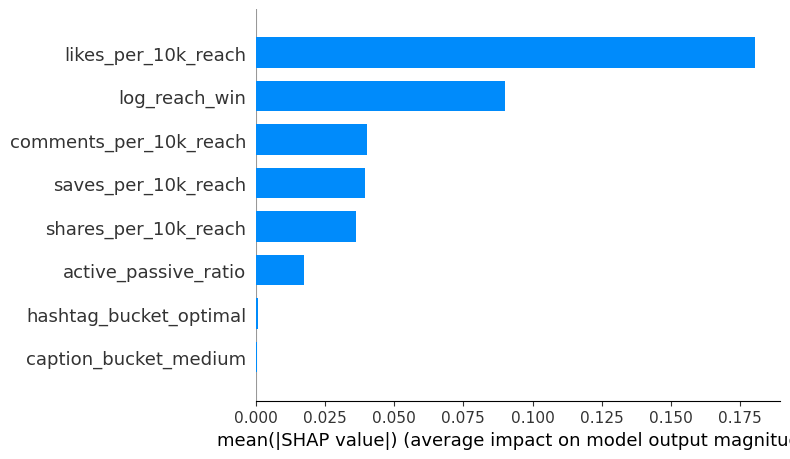

In [60]:
shap.summary_plot(
    shap_class1,
    X_test,
    plot_type="bar"
)

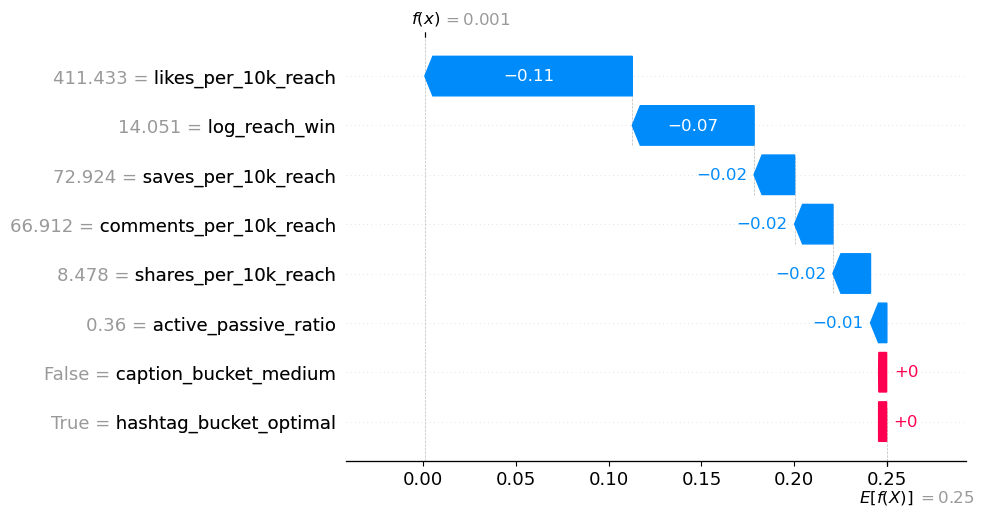

In [62]:
shap.plots.waterfall(
    shap.Explanation(
        values=shap_class1[i],
        base_values=explainer.expected_value[1]
        if isinstance(explainer.expected_value, list)
        else explainer.expected_value[1],
        data=X_test.iloc[i],
        feature_names=X_test.columns
    )
)

Inisghts

1. Likes Volume as a Standalone Can Hurt Engagement Quality
- SHAP waterfall: High likes_per_10k_reach contributes negatively to the prediction.
- Global SHAP: Likes have the largest impact, but not always in a positive direction.

**Implication**: Posts that rely heavily on likes without proportional comments, saves, or shares are less likely to be classified as high engagement quality. Likes are a weak, sometimes misleading signal when isolated.

2. Reach as a Control
- log_reach_win is the second most influential feature globally.
- In the local explanation, higher reach pulls the prediction downward.

**Implication**: High reach increases exposure but does not guarantee meaningful engagement. After normalization, reach often dilutes engagement quality, reinforcing the need to evaluate performance relative to exposure.

3. Active Engagement Signals (Real Positive Drivers)
- Comments, saves, shares, and active_passive_ratio consistently push predictions toward high engagement quality.
- Content structure features (caption length, hashtags) have minimal impact compared to behavior.

**Implication**: Meaningful interactions, not content formatting, are the strongest indicators of engagement quality. Engagement depth is driven by what users do, not how the post is packaged.

**Key Takeways**
High-quality engagement is defined by interaction depth, not reach or likes. Models that prioritize behavioral signals over vanity metrics produce more reliable insights.

In [64]:
X.columns.tolist()

['likes_per_10k_reach',
 'comments_per_10k_reach',
 'shares_per_10k_reach',
 'saves_per_10k_reach',
 'active_passive_ratio',
 'log_reach_win',
 'caption_bucket_medium',
 'hashtag_bucket_optimal']

In [63]:
# Final Model
final_model = rf_model
joblib.dump(final_model, "model.pkl")

['model.pkl']